In [1]:
using JLD
using PyPlot
using Statistics, StatsBase
using Clustering
using Distances  # Este es necesario para hacer la matriz de distancia, es complemento a Clustering.

┌ Info: Recompiling stale cache file /home/karel/.julia/compiled/v1.0/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1190


In [2]:
push!(LOAD_PATH, "../Preprocesamiento/")
using ArraySetTools # pa aprovechar las cosas que ya tenemos.

In [3]:
function normalizar1(xx::Array)
    norma=maximum(abs.(xx))
    result=xx./norma
    return result
end

normalizar1 (generic function with 1 method)

In [4]:
function filtraclusterchicos(puntos::Array, clustree, umbral)
    tabla=hcat(puntos,clustree)
    valores=unique(clustree)
    dd=Dict([(i,count(x->x==i,clustree)) for i in valores])
    predicado(j)=dd[j]>umbral
    result=tabla[map(x->predicado(x), clustree),:]
    (clusterfuck, cual)=findmax(dd)
    println("el cluster mayor tiene ",clusterfuck, " elementos, es el ", cual)
    return result
end

function filtraclusterchicos(puntos::Dict, umbral)
    # no solo aqui ya estan separados por dicctionario, sino tambien
    # en "electrodos", es decir numeros enteros
   result=Dict{Int, Set}()
    for k in keys(puntos)
        if length(puntos[k])>umbral
            result[k]=puntos[k]
        end
    end
    return result
end

filtraclusterchicos (generic function with 2 methods)

In [176]:


function declustaset(puntosyclust::Array; enteros=true)
    #= la funcion convierte el cluster en una tabla
    a un conjunto de enteros, sobre una malla 
    =#
    
    result=Dict{Int,Set}()
    clustnames=unique(puntosyclust[:,end])
    
    for q in clustnames
        subt=puntosyclust[puntosyclust[:,end].==q,:]
       if enteros
        punt=rowstoset(round.(Int64,subt[:,end]))
        else
            punt=rowstoset(subt[:,end], enteros=enteros)
        end    
        qindez=round(Int64,q)
        result[qindez]=punt
    end
    return result

end



declustaset (generic function with 1 method)

In [178]:
#funcion solo para plotear, no se si luego la vas a usar.
function dictatabla(dict::Dict; ancho=4, una=true)
    # si una, entonces todo va en una tabla, si no, va en tablitas separadas
    
    
    if una 
        aux=zeros(1,ancho+1)
    else
        aux=Dict{Any, Any}()
    end
     println("vamos bien 1 ")
    
    for q in keys(dict)
        
        aux2=zeros(1,ancho)
        
        for renglon in dict[q]
            aux2=vcat(aux2, renglon)
            rintln("vamos bien 2")
        end
        
        println("vamos bien 3")
        
        aux2=aux2[2:end,:]
        
        (l,k)=size(aux2)
        columnaextra=ones(Int64, l).*q
        aux3=hcat(aux2, columnaextra)
        
        println("a ver")
        
        
        if una
            aux=vcat(aux, aux3)
        else
            aux[q]=aux2
        end
    end
    
    if una
        return aux[2:end,:]
    else
        return aux
    end
end


dictatabla (generic function with 1 method)

In [179]:
nombrecm="/home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_prepro-CM.jld"
archivo=load(nombrecm)
DatosCMP=archivo["CMP"]
DatosCMN=archivo["CMN"];
evocada=false
nmax=length(DatosCMP)

2000

In [180]:
# Datos ordenados 4dimensionalmente.
# vamos a usar masa maxima y tiempo maximo normalizados a 64 (dist max.)
# para hacer un hipercubo platonico y hacer el apiñonamiento jerárquico ahi.

fruncio=Array{Float64}(undef, 0,4)

for k in keys(DatosCMP)
    dat=DatosCMP[k]
    (alto, ancho)=size(dat)
    auxt=ones(alto).*k
    afafa=hcat(dat, auxt)
    fruncio=vcat(fruncio,afafa)
end

fruncio=fruncio[sortperm(fruncio[:, 4]), :];

In [181]:
masamax=maximum(fruncio[:,3])

12329.550282478333

In [182]:
nmax=maximum(fruncio[:,4])

2000.0

In [183]:
function plot4Ddiscs(datos::Array; escala=0.05)
    figure(figsize=(8,6.5))
    
    xx=datos[:,1]
    yy=datos[:,2]
    gordis=datos[:,3]
    nn=datos[:,4]
    
    xlim(0.0,65.0)
    ylim(0.0,65.0)
    
    
    scatter(xx,yy, s=escala*gordis, edgecolors="darkmagenta", c=nn, cmap="plasma", lw=0.5)
    colorbar()
    show()
end


plot4Ddiscs (generic function with 1 method)

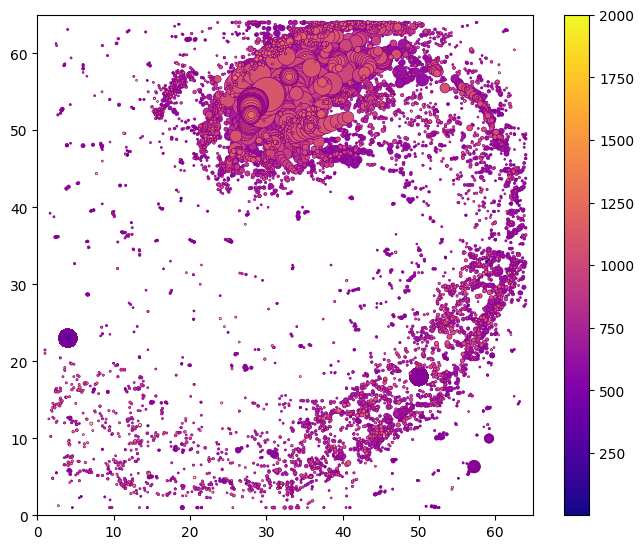

In [184]:
fig=plot4Ddiscs(fruncio)


In [185]:
histogordis=fit(Histogram, fruncio[:,3], 1:20:5001)

Histogram{Int64,1,Tuple{StepRange{Int64,Int64}}}
edges:
  1:20:5001
weights: [0, 386, 2840, 1481, 885, 491, 324, 242, 178, 162  …  1, 3, 3, 1, 3, 3, 1, 1, 3, 0]
closed: left
isdensity: false

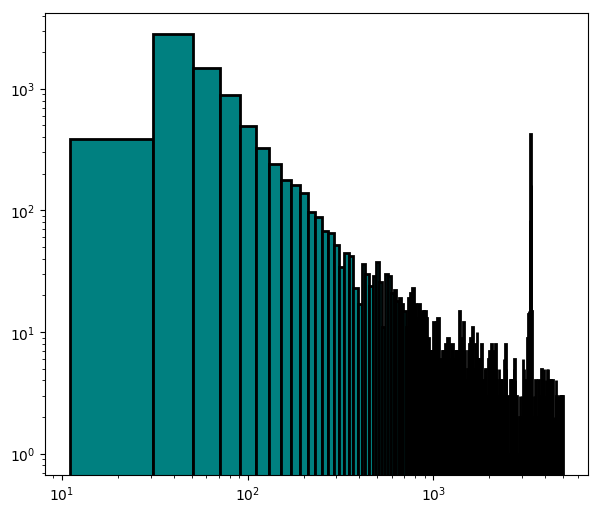

In [186]:
#histogordis.weights
figure(figsize=(7,6))
bar(histogordis.edges[1][1:end-1], histogordis.weights, width=20, 
    color="teal", edgecolor="k", linewidth=2)
yscale("log")
xscale("log")
show()

In [187]:
gmin=nquantile(fruncio[:,3], 10)[2]

44.147528648376465

In [188]:
frunciofiltrado=fruncio[fruncio[:,3].>gmin,:]
size(frunciofiltrado)

(8856, 4)

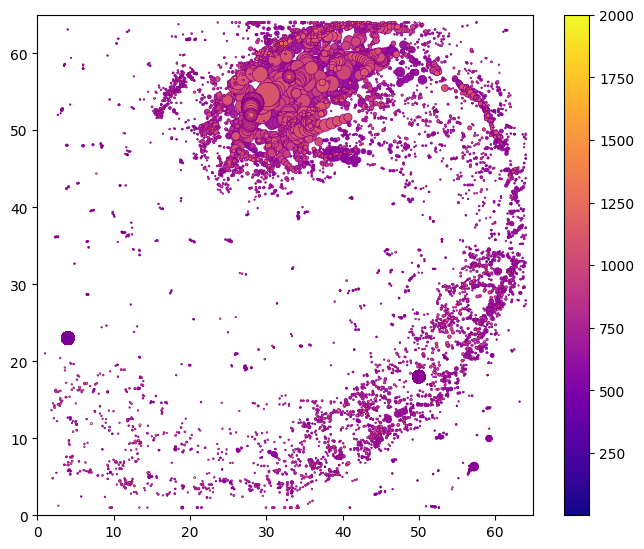

In [189]:
plot4Ddiscs(frunciofiltrado, escala=0.025)


In [190]:
# clust1=fruncio[:,1:2];
clust1=permutedims(frunciofiltrado)

4×8856 Array{Float64,2}:
 46.7927  27.3672   30.7173  55.1767   …    24.1639    11.3209     2.75101
 54.6672   4.15315  56.2334   4.80699       14.6006    49.6291     1.24794
 45.3749  63.8133   46.5284  47.0146        56.2697    64.1216    45.5731 
  1.0      1.0       1.0      1.0         2000.0     2000.0     2000.0    

In [191]:
clust1[3,:]=normalizar1(clust1[3,:]).*64
clust1[4,:]=normalizar1(clust1[4,:]).*64;

In [192]:
clustspaciotiempo=vcat(clust1[1:2,:], transpose(clust1[4,:]))

3×8856 Array{Float64,2}:
 46.7927  27.3672   30.7173  55.1767   …  60.5552  24.1639  11.3209   2.75101
 54.6672   4.15315  56.2334   4.80699     57.4671  14.6006  49.6291   1.24794
  0.032    0.032     0.032    0.032       64.0     64.0     64.0     64.0    

In [193]:
# decisiones, decisiones
dd4d=pairwise(Euclidean(), clust1, dims=2);
dd3d=pairwise(Euclidean(), clustspaciotiempo, dims=2);
dd2d=pairwise(Euclidean(), clust1[1:2,:], dims=2);

In [194]:
h4d=hclust(dd4d)
h3d=hclust(dd3d)
h2d=hclust(dd2d)

Hclust{Float64}([-137 -154; -32 -317; … ; 5286 8853; 4636 8854], [9.36836e-6, 1.08421e-5, 2.18722e-5, 2.27687e-5, 2.388e-5, 2.38943e-5, 2.3937e-5, 2.90832e-5, 3.26346e-5, 3.26485e-5  …  3.89438, 3.93271, 4.08506, 4.10886, 4.23181, 4.28125, 4.37309, 4.37604, 4.53162, 4.92297], [956, 1200, 1037, 1116, 2414, 2429, 2450, 1068, 1234, 1298  …  1181, 1256, 1319, 1279, 1130, 838, 873, 919, 991, 1076], :single)

In [195]:
hcorta=4.55 #estrictamente menos que un electrodo.
clust4d=cutree(h4d,h=hcorta)
clust3d=cutree(h3d,h=hcorta)
clust2d=cutree(h2d,h=hcorta);

In [126]:
size(unique(clust4d))

(103,)

In [127]:
function scatterclust(puntos, clustn)

fafa=figure(figsize=(4,4))
#axis("equal")

xlim(0.0,65.0)
ylim(0.0,65.0)
scatter(puntos[:,1],puntos[:,2], s=0.5, c=clustn, cmap="inferno")
colorbar(fraction=0.045)
end

scatterclust (generic function with 1 method)

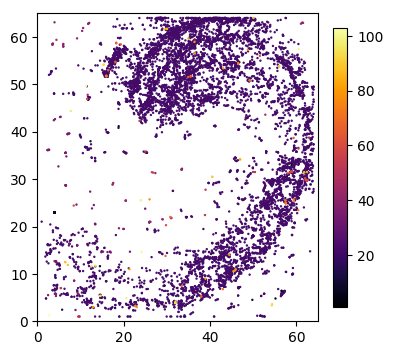

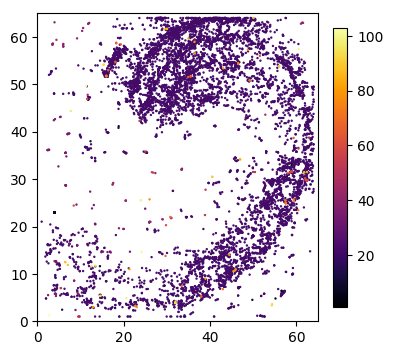

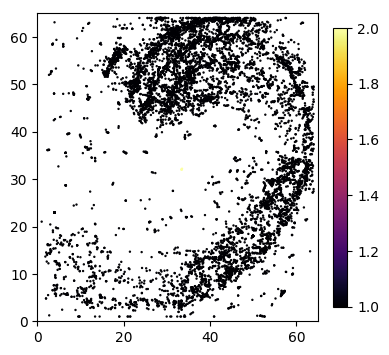

PyObject <matplotlib.colorbar.Colorbar object at 0x7fb70aa149e8>

In [128]:
scatterclust(frunciofiltrado, clust4d)
scatterclust(frunciofiltrado, clust3d)
scatterclust(frunciofiltrado,clust2d)

In [145]:
temp=hcat(frunciofiltrado, clust3d)
dict3d=declustaset(temp, enteros=true)
blabla3d=filtraclusterchicos(dict3d, 3);

In [155]:
a=zeros(1,4)

1×4 Array{Float64,2}:
 0.0  0.0  0.0  0.0

In [167]:
show(blabla3d[32])

Set(Array{Int64,2}[[37 60 53 362 32], [37 60 50 365 32], [36 59 52 384 32], [37 60 47 361 32], [36 59 66 385 32], [37 60 58 363 32], [36 59 55 387 32], [37 60 66 364 32], [36 59 54 386 32]])

In [164]:
blatabla3d=dictatabla(blabla3d);
#buf=dictatabla(blabla3d, una=false)

vamos bien 1 


ArgumentError: ArgumentError: number of columns of each array must match (got (4, 5))

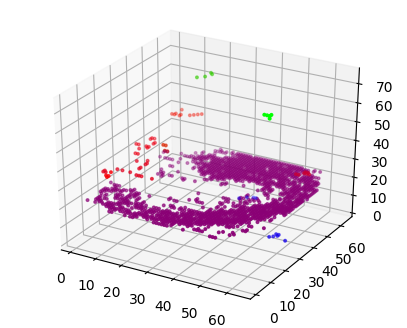

PyObject <mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x7fb687a67ba8>

In [143]:
fafa=figure(figsize=(5,4))

ax=gca()
ax.set_facecolor("k")
axis("equal")

xlim(0.0,65.0)
ylim(0.0,65.0)
scatter3D(blatabla3d[:,1], blatabla3d[:,2],blatabla3d[:,3], c=blatabla3d[:,3], s=3.5, cmap="brg")
#colorbar()

In [120]:
unique(blatabla[:,3])

187-element Array{Int64,1}:
  520
 1316
  708
 1248
  464
  542
  289
 1169
   31
  285
  886
  445
  779
    ⋮
  304
 1012
  116
  687
 1311
 1038
 1241
  498
  315
  496
 1196
  839

In [63]:
using QHull

In [37]:
convexas=Dict{Any, Any}()
for k in keys(buf)
    puf =buf[k]
    print(k, " ")
    ch = chull(puf)
    convexas[k]=ch
end

377 2 520 486 495 391 155 142 356 900 236 57 14 893 490 705 121 114 451 165 96 83 965 368 64 970 738 4 145 127 951 126 99 141 359 128 157 334 104 353 395 1212 61 313 482 154 120 225 484 364 62 623 102 540 88 1203 119 917 222 869 686 463 472 603 27 164 362 581 

In [38]:
poly=PyPlot.matplotlib.patches.Polygon
appnplot=PyPlot.matplotlib.patches
colect=matplotlib.collections.PatchCollection

PyObject <class 'matplotlib.collections.PatchCollection'>

In [39]:
keys(colect)

166-element Array{Symbol,1}:
 :__class__            
 :__delattr__          
 :__dict__             
 :__dir__              
 :__doc__              
 :__eq__               
 :__format__           
 :__ge__               
 :__getattribute__     
 :__getstate__         
 :__gt__               
 :__hash__             
 :__init__             
 ⋮                     
 :set_transform        
 :set_url              
 :set_urls             
 :set_visible          
 :set_zorder           
 :stale                
 :sticky_edges         
 :to_rgba              
 :update               
 :update_from          
 :update_scalarmappable
 :zorder               

In [40]:
orderhull=Dict{Any, Any}()
for k in keys(convexas)
    plaf=[0 0]
    for j in convexas[k].vertices
        aux=transpose(convexas[k].points[j,:])
        plaf=vcat(plaf, aux)
    end
    orderhull[k]=plaf[2:end,:]
end

In [49]:
f=figure(figsize=(6,6))
fig, ax = plt.subplots()
popo=[]
for k in values(orderhull)
    punch=poly(k, true)
    push!(popo, punch)
end
cucu=colect(popo, alpha=0.5)
cucu.set_array(1:50)
ax.add_collection(cucu)
fig.colorbar(cucu, ax=ax)

#savefig("tuabuela.png", dpi=92)
show(f)

Figure(PyObject <Figure size 640x480 with 2 Axes>)

Figure(PyObject <Figure size 600x600 with 0 Axes>)

68-element Array{Any,1}:
 PyObject <matplotlib.patches.Polygon object at 0x7fb68822cef0>
 PyObject <matplotlib.patches.Polygon object at 0x7fb688237048>
 PyObject <matplotlib.patches.Polygon object at 0x7fb688237160>
 PyObject <matplotlib.patches.Polygon object at 0x7fb688237278>
 PyObject <matplotlib.patches.Polygon object at 0x7fb688237390>
 PyObject <matplotlib.patches.Polygon object at 0x7fb6882374a8>
 PyObject <matplotlib.patches.Polygon object at 0x7fb6882375c0>
 PyObject <matplotlib.patches.Polygon object at 0x7fb6882376d8>
 PyObject <matplotlib.patches.Polygon object at 0x7fb6882377f0>
 PyObject <matplotlib.patches.Polygon object at 0x7fb688237908>
 PyObject <matplotlib.patches.Polygon object at 0x7fb688237a20>
 PyObject <matplotlib.patches.Polygon object at 0x7fb688237b38>
 PyObject <matplotlib.patches.Polygon object at 0x7fb688237c50>
 ⋮                                                             
 PyObject <matplotlib.patches.Polygon object at 0x7fb68824bd30>
 PyObject <matp